# Database Connection - Linear Regression

### Outline:

- connect to Postgres Database in AWS.
- load economic features and target table into Dataframe
- additional Data manipulation in Dataframe
- train model and evaluate results

## Import Dependencies
**config.py**  file is needed to connect to AWS database

You may need to run these pip install in the correct conda environment:
$   pip install psycopg2
$   pip install psycopg2-binary 

In [1]:
# Import dependencies
from sqlalchemy import inspect, create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import config as creds
import pandas as pd

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.datasets as datasets

# For splitting of data into train and test set
from sklearn.model_selection import train_test_split

# Metrics for Evaluation of model Accuracy and F1-score
from sklearn.metrics  import f1_score,accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics

In [2]:
#!pip install psycopg2

In [3]:
#!pip install psycopg2-binary 

## Connect to postgres database in AWS, read data into a Dataframe

In [4]:
# Create engine
engine = create_engine(f'postgresql://{creds.PGUSER}:{creds.PGPASSWORD}@{creds.PGHOST}:5432/{creds.PGDATABASE}')

In [5]:
# Create our session (link) from Python to the DB
session = Session(bind=engine.connect())

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# List tables in database
inspect(engine).get_table_names()

['economic_features_full',
 'features_table',
 'target_table',
 'economic_features',
 'high_low_poverty']

In [8]:
# List columns in a specific table ('min_wage')
[column['name'] for column in inspect(engine).get_columns('economic_features')]

['year',
 'state',
 'population_million',
 'education_million',
 'welfare_million',
 'crime_rate',
 'unemployment_rate',
 'divorce_rate_per_1000_people',
 'homeownership_rate',
 'minimum_wage_effective',
 'cpi_average',
 'inflation_rate',
 'avg_wage_index',
 'poverty_rate']

In [9]:
# Defining function that takes in a table name and outputs a dataframe
def db_reader(tablename):
    table_df = pd.read_sql_table(f'{tablename}', engine)
    return table_df

In [10]:
# Reading a database table into a dataframe
econ_features_full = db_reader('economic_features_full')
econ_features_full.head()

year     state  population_million  education_million  welfare_million  \
0  1970  National             203.302            56456.0          18738.8   
1  1971  National             205.515            63469.0          27364.3   
2  1972  National             207.752            71351.0          30594.3   
3  1973  National             210.013            75849.0          28944.9   
4  1974  National             212.299            81440.0          34816.4   

   crime_rate  unemployment_rate  divorce_rate_per_1000_people  \
0       363.5                NaN                          3.50   
1       396.0                NaN                          3.75   
2       401.0                NaN                          4.00   
3       417.4                NaN                          4.25   
4       461.1                NaN                          4.50   

   homeownership_rate  minimum_wage_effective  cpi_average  inflation_rate  \
0                 NaN                1.382353         38.8             5.8   
1                 NaN                1.382353         40.5             4.3   
2                 NaN                1.623529         41.8             3.3   
3                 NaN                1.623529         44.4             6.2   
4                 NaN                1.623529         49.3            11.1   

   avg_wage_index  poverty_rate  
0         6186.24         17.18  
1         6497.08         17.05  
2         7133.80         16.12  
3         7580.16         15.13  
4         8030.76         15.86

## Additional data processing

In [11]:
# Calculate additional features

econ_features_full['education_per_capita'] = econ_features_full['education_million'] / econ_features_full['population_million']
econ_features_full['welfare_per_capita'] = econ_features_full['welfare_million'] / econ_features_full['population_million']


In [12]:
# Drop the non-beneficial columns
columns_to_drop = ['education_million','welfare_million', 'population_million']
model_df = econ_features_full.drop(columns=columns_to_drop, axis=1)

# Drop 'District of Columbia' information
model_df.drop(model_df[model_df['state']=='District of Columbia'].index, inplace=True)

model_df.head()

year     state  crime_rate  unemployment_rate  \
0  1970  National       363.5                NaN   
1  1971  National       396.0                NaN   
2  1972  National       401.0                NaN   
3  1973  National       417.4                NaN   
4  1974  National       461.1                NaN   

   divorce_rate_per_1000_people  homeownership_rate  minimum_wage_effective  \
0                          3.50                 NaN                1.382353   
1                          3.75                 NaN                1.382353   
2                          4.00                 NaN                1.623529   
3                          4.25                 NaN                1.623529   
4                          4.50                 NaN                1.623529   

   cpi_average  inflation_rate  avg_wage_index  poverty_rate  \
0         38.8             5.8         6186.24         17.18   
1         40.5             4.3         6497.08         17.05   
2         41.8             3.3         7133.80         16.12   
3         44.4             6.2         7580.16         15.13   
4         49.3            11.1         8030.76         15.86   

   education_per_capita  welfare_per_capita  
0            277.695251           92.172236  
1            308.829039          133.149892  
2            343.443144          147.263564  
3            361.163357          137.824325  
4            383.609909          163.997004

## Model for 1 state

In [13]:
# List of states
model_df.state.unique()

array(['National', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware', 'Nebraska',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Wisconsin', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wyoming'], dtype=object)

In [14]:
# Pick data for 1 state
state_to_model = 'Texas'
model_state_df = model_df.loc[model_df['state']==state_to_model].dropna().set_index('year')
model_state_df.drop(columns=['state'], inplace=True)
model_state_df

crime_rate  unemployment_rate  divorce_rate_per_1000_people  \
year                                                                
1984       505.0                6.1                        4.9778   
1985       550.0                7.0                        4.9222   
1986       658.9                8.8                        4.8667   
1987       631.1                8.5                        4.8111   
1988       652.6                7.4                        4.7556   
1989       658.5                6.7                        4.7000   
1990       761.4                6.4                        4.7000   
1991       840.1                7.0                        4.6429   
1992       806.3                7.7                        4.5857   
1993       762.1                7.2                        4.5286   
1994       706.5                6.6                        4.4714   
1995       663.9                6.1                        4.4143   
1996       644.4                5.8                        4.3571   
1997       602.5                5.4                        4.3000   
1998       564.6                5.0                        4.2000   
1999       560.3                4.7                        4.1000   
2000       545.1                4.4                        4.0000   
2001       571.6                5.0                        4.0000   
2002       579.7                6.3                        3.9000   
2003       553.1                6.7                        3.8000   
2004       540.9                6.0                        3.7000   
2005       528.1                5.5                        3.6000   
2006       517.3                5.0                        3.7000   
2007       510.4                4.4                        3.6000   
2008       508.0                4.9                        3.5000   
2009       491.0                7.5                        3.5000   
2010       448.4                8.2                        3.6000   
2011       408.6                8.0                        3.6000   
2012       408.6                6.7                        3.4000   
2013       410.3                6.3                        3.3000   
2014       406.7                5.2                        3.2000   
2015       412.7                4.5                        3.1000   
2016       433.8                4.6                        3.0100   
2017       437.8                4.3                        2.9000   
2018       412.9                3.9                        2.9000   
2019       418.9                3.5                        2.7000   

      homeownership_rate  minimum_wage_effective  cpi_average  inflation_rate  \
year                                                                            
1984                62.5                    3.35      103.900             4.3   
1985                60.5                    3.35      107.600             3.5   
1986                61.0                    3.35      109.600             1.9   
1987                61.1                    3.35      113.600             3.7   
1988                59.9                    3.35      118.300             4.1   
1989                61.0                    3.35      124.000             4.8   
1990                59.7                    3.35      130.700             5.4   
1991                59.0                    3.80      136.200             4.2   
1992                58.3                    4.25      140.300             3.0   
1993                58.7                    4.25      144.500             3.0   
1994                59.7                    4.25      148.200             2.6   
1995                61.4                    4.25      152.400             2.8   
1996                61.8                    4.25      156.900             2.9   
1997                61.5                    4.75      160.500             2.3   
1998                62.5                    5.15      163.000             1.6   
1999  

In [15]:
# Define X and y variables
X = model_state_df.drop(["poverty_rate"], axis=1)  #.values.reshape(-1, 1)
y = model_state_df["poverty_rate"]
print(f'X shape: {X.shape}')
X.head()

X shape: (36, 10)


crime_rate  unemployment_rate  divorce_rate_per_1000_people  \
year                                                                
1984       505.0                6.1                        4.9778   
1985       550.0                7.0                        4.9222   
1986       658.9                8.8                        4.8667   
1987       631.1                8.5                        4.8111   
1988       652.6                7.4                        4.7556   

      homeownership_rate  minimum_wage_effective  cpi_average  inflation_rate  \
year                                                                            
1984                62.5                    3.35        103.9             4.3   
1985                60.5                    3.35        107.6             3.5   
1986                61.0                    3.35        109.6             1.9   
1987                61.1                    3.35        113.6             3.7   
1988                59.9                    3.35        118.3             4.1   

      avg_wage_index  education_per_capita  welfare_per_capita  
year                                                            
1984        16135.07            841.894723          201.839728  
1985        16822.51            915.642889          205.628095  
1986        17321.82            986.350711          224.000000  
1987        18426.51            988.999255          272.547802  
1988        19334.04           1021.018603          264.812443

In [16]:
model_state_df.dtypes

crime_rate                      float64
unemployment_rate               float64
divorce_rate_per_1000_people    float64
homeownership_rate              float64
minimum_wage_effective          float64
cpi_average                     float64
inflation_rate                  float64
avg_wage_index                  float64
poverty_rate                    float64
education_per_capita            float64
welfare_per_capita              float64
dtype: object

In [17]:
#  CHECK IF THIS IS NEEDED ********************************************
# std = preprocessing.StandardScaler()
# X is a matrix
#std.fit(X)
#X_std = std.transform(X)

In [18]:
# Create a model with scikit-learn
model = LinearRegression()

In [19]:
# Test the model by using train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Fit the data into the model
# By convention, X is capitalized and y is lowercase
model.fit(X, y)

LinearRegression()

In [21]:
# We use the predict() on the model to predict the output
# The model creates predicted y values based on X values
y_pred = model.predict(X)
print(y_pred.shape)
print(X.shape)


(36,)
(36, 10)


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
print(f'Mean absolute error: {mean_absolute_error(y,y_pred)}')
print(f'Mean square error: {mean_squared_error(y,y_pred)}')
print(f'r2 score: {r2_score(y,y_pred)}')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

Mean absolute error: 0.23794051762215243
Mean square error: 0.0924684437180123
r2 score: 0.9868276688010447
Coefficients: [-2.75639160e-03  5.80483028e-01 -9.49998425e-01 -2.16256191e-01
 -9.51270850e-01 -2.85373127e-02  1.35402703e-01  1.30236874e-04
 -1.85824303e-03 -8.12794037e-04]
Intercept: 43.075818882869484


In [23]:
model_state_df['predicted_poverty'] = y_pred
model_state_df.head()

crime_rate  unemployment_rate  divorce_rate_per_1000_people  \
year                                                                
1984       505.0                6.1                        4.9778   
1985       550.0                7.0                        4.9222   
1986       658.9                8.8                        4.8667   
1987       631.1                8.5                        4.8111   
1988       652.6                7.4                        4.7556   

      homeownership_rate  minimum_wage_effective  cpi_average  inflation_rate  \
year                                                                            
1984                62.5                    3.35        103.9             4.3   
1985                60.5                    3.35        107.6             3.5   
1986                61.0                    3.35        109.6             1.9   
1987                61.1                    3.35        113.6             3.7   
1988                59.9                    3.35        118.3             4.1   

      avg_wage_index  poverty_rate  education_per_capita  welfare_per_capita  \
year                                                                           
1984        16135.07          22.4            841.894723          201.839728   
1985        16822.51          22.4            915.642889          205.628095   
1986        17321.82          22.6            986.350711          224.000000   
1987        18426.51          22.7            988.999255          272.547802   
1988        19334.04          22.3           1021.018603          264.812443   

      predicted_poverty  
year                     
1984          21.783203  
1985          22.402431  
1986          22.736711  
1987          22.899454  
1988          22.498910

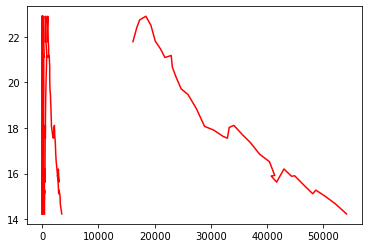

In [24]:
# Plot the results. The best fit line is red.
#model_state_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=state_to_model )
plt.plot(X, y_pred, color='red')
#plt.show()

In [25]:
# The slope
# The y-intercept
print(model.coef_)
print(model.intercept_)

[-2.75639160e-03  5.80483028e-01 -9.49998425e-01 -2.16256191e-01
 -9.51270850e-01 -2.85373127e-02  1.35402703e-01  1.30236874e-04
 -1.85824303e-03 -8.12794037e-04]
43.075818882869484


## Create Function

In [26]:
def run_model(df, state='National', model_type='linear'):
    m_df = df.loc[df['state']==state].dropna().set_index('year')
    m_df.drop(columns=['state'], inplace=True)

    # Define X and y variables
    X = m_df.drop(["poverty_rate"], axis=1)
    y = m_df["poverty_rate"]

    # Create a model with scikit-learn
    if model_type=='linear':
        model = LinearRegression()
    elif model_type =='ridge':
        model = Ridge(alpha=0.5)
    elif model_type == 'lasso':
        model = Lasso(alpha=0.1, max_iter=1500, tol=0.01)
    else:
        model = LinearRegression()
        
    # Fit the data into the model
    model.fit(X, y)
    # We use the predict() on the model to predict the output
    # The model creates predicted y values based on X values
    
    y_pred = model.predict(X)
    m_df['predicted_poverty'] = y_pred
    m_df.plot(y=['poverty_rate','predicted_poverty'], use_index=True, title=f'{state}:{model_type}')
    
    results = { 'State': state,
                'Model': model_type,
                'Mean absolute error': mean_absolute_error(y,y_pred),
                'Mean square error': mean_squared_error(y,y_pred),
                'r2 score': r2_score(y,y_pred),
                'Coefficients': model.coef_,
                'Intercept': model.intercept_
              }
    return results
    

C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


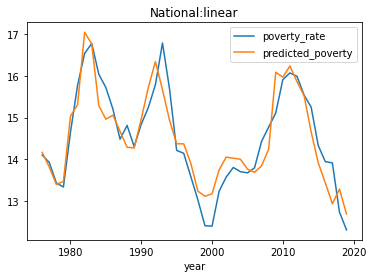

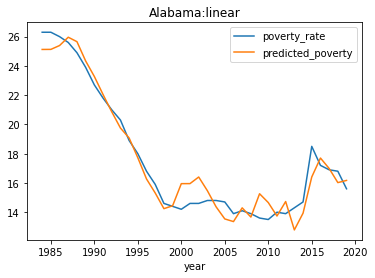

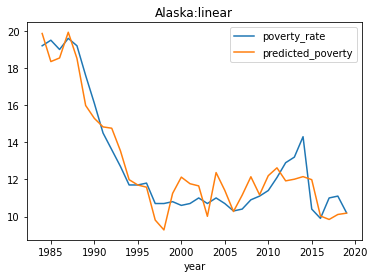

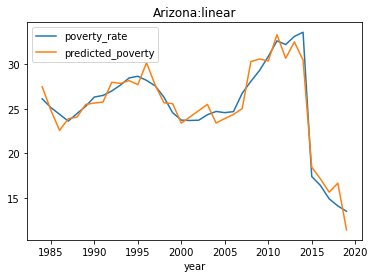

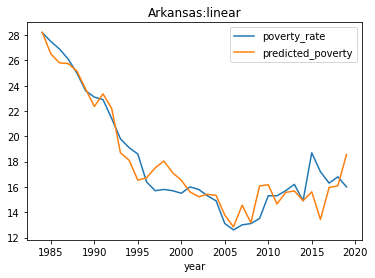

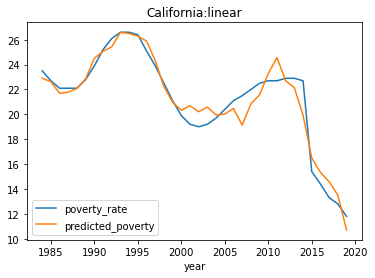

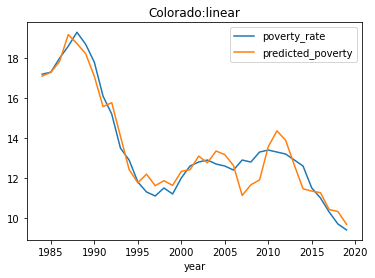

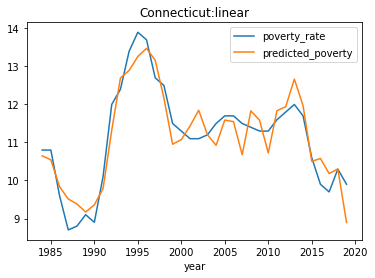

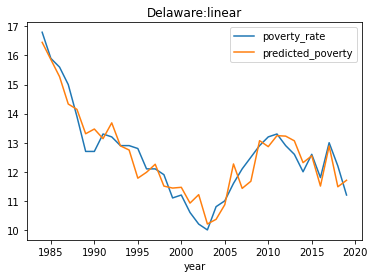

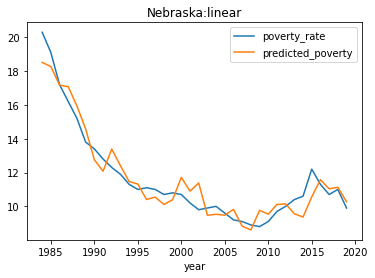

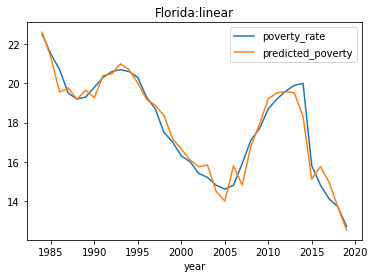

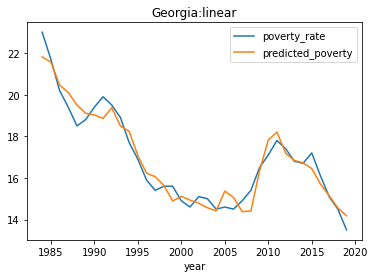

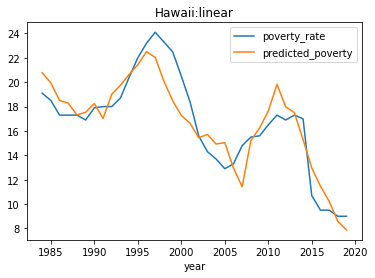

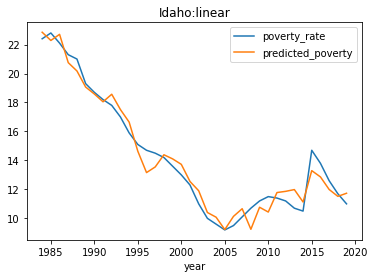

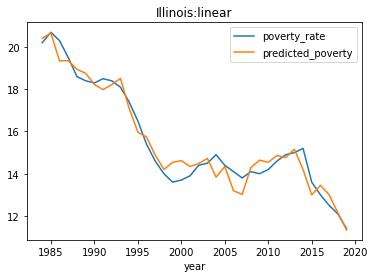

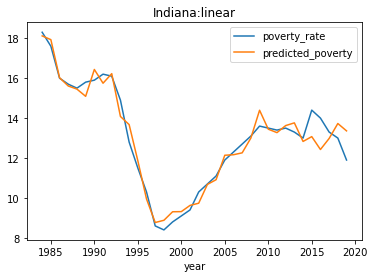

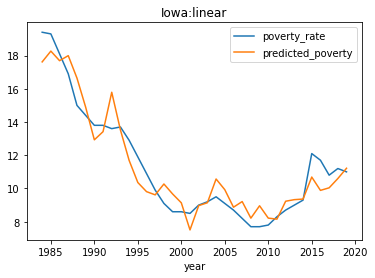

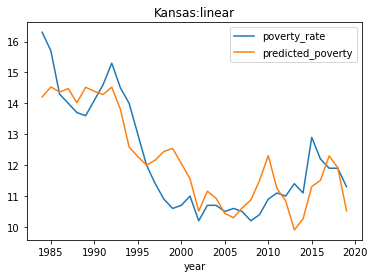

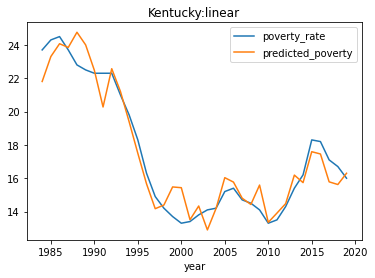

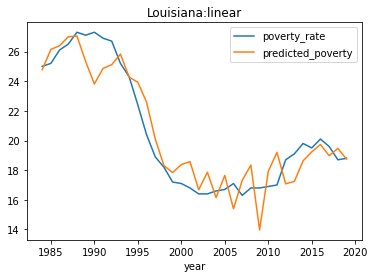

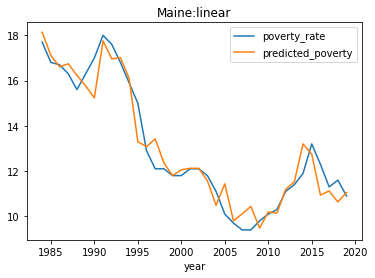

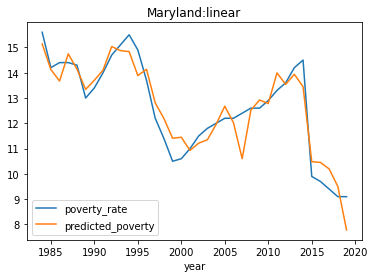

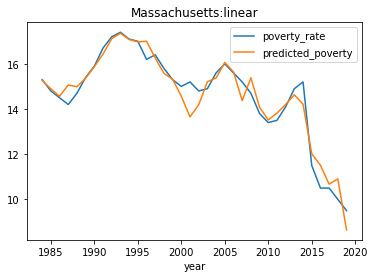

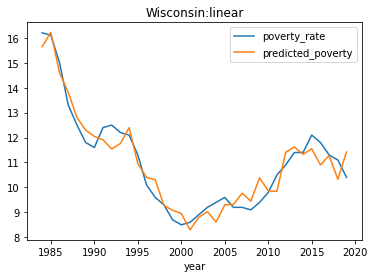

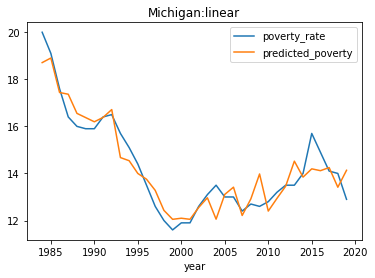

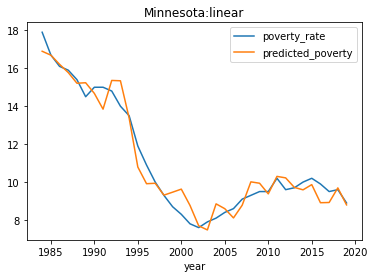

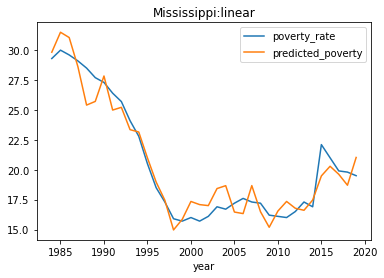

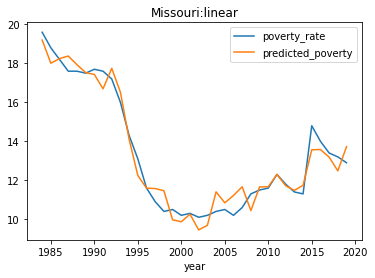

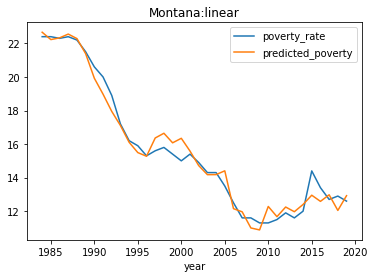

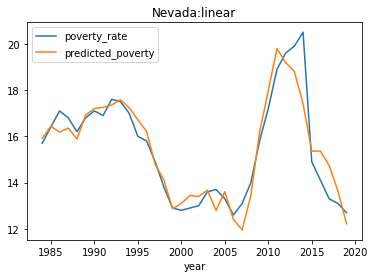

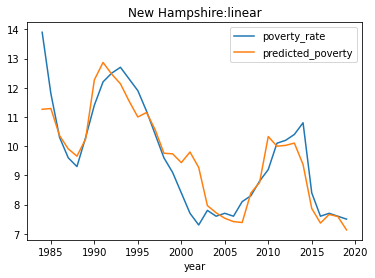

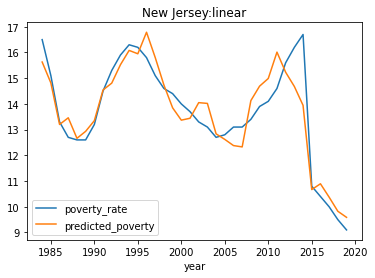

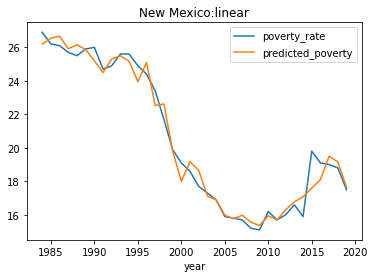

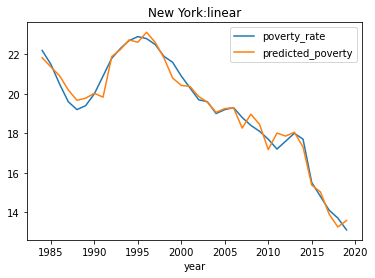

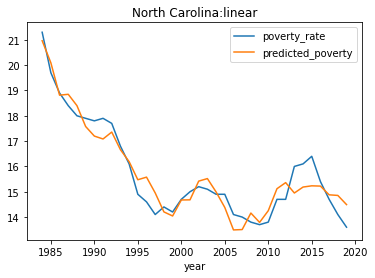

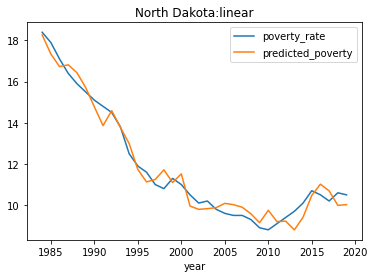

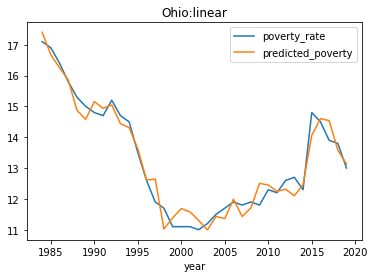

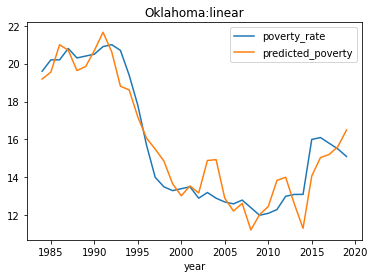

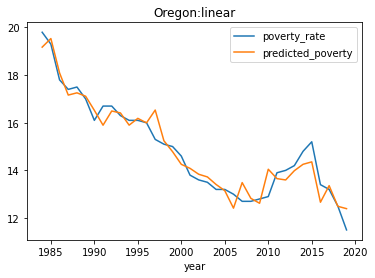

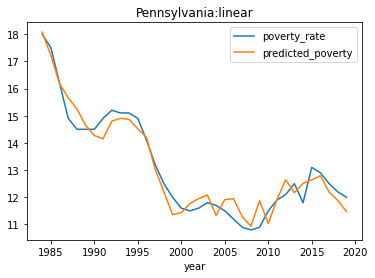

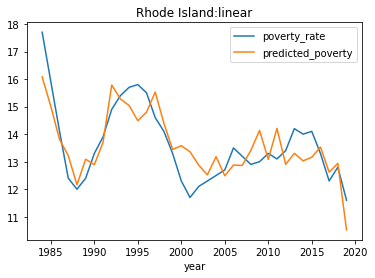

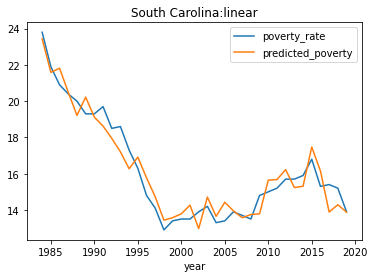

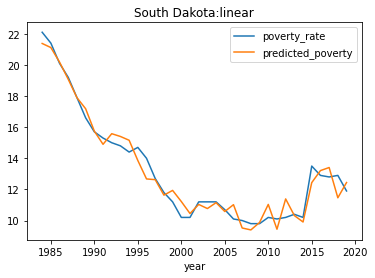

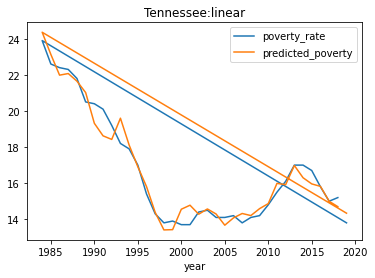

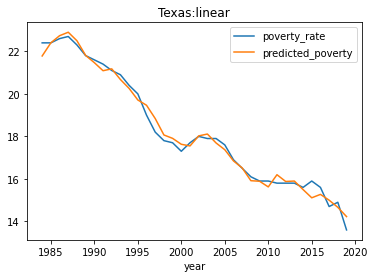

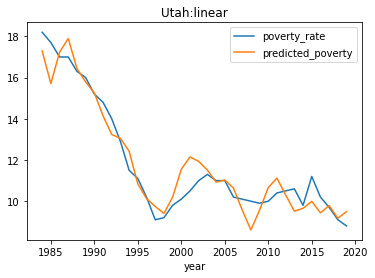

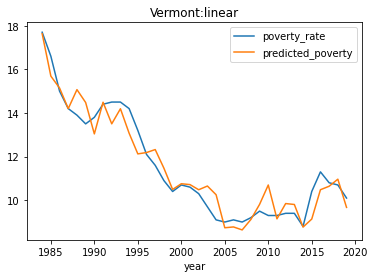

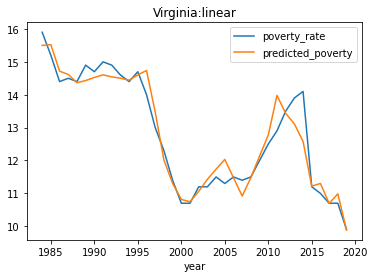

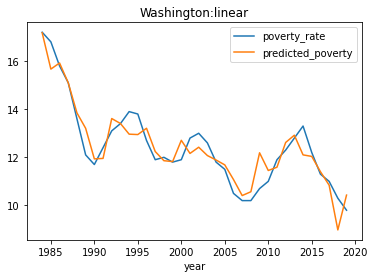

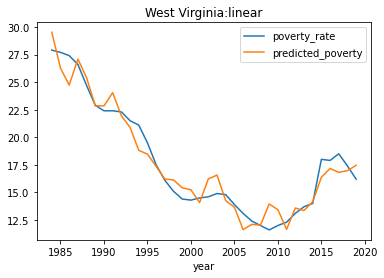

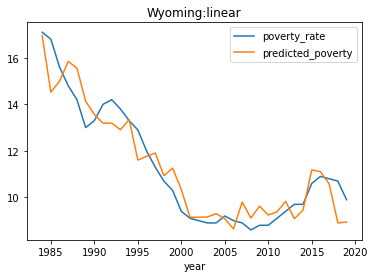

In [27]:
result_df = pd.DataFrame()
for state in model_df.state.unique():
    result = run_model(model_df, state, 'linear')
    result_df = result_df.append(result, ignore_index=True)


C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


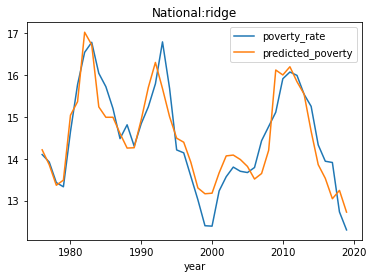

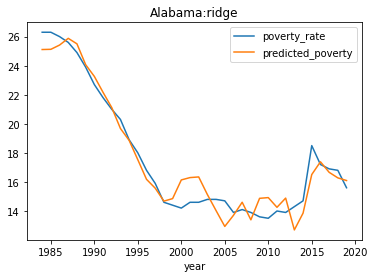

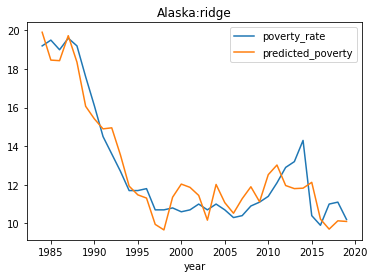

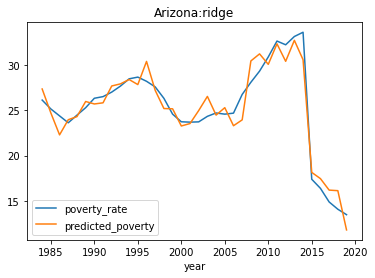

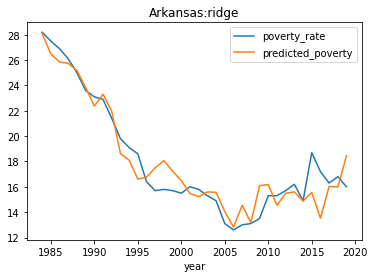

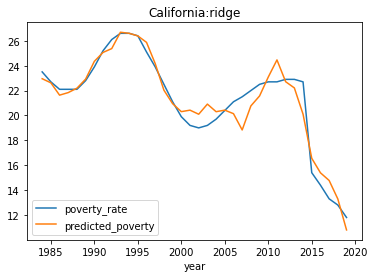

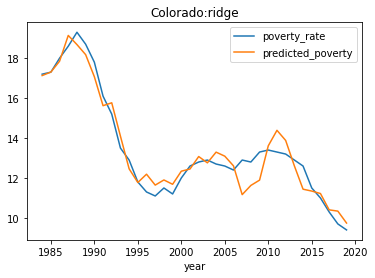

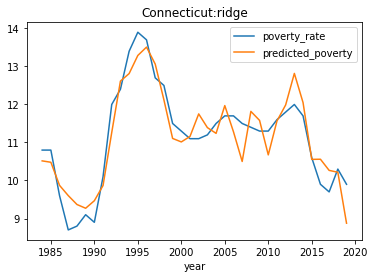

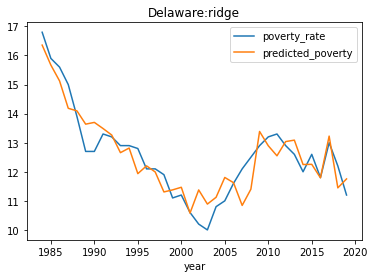

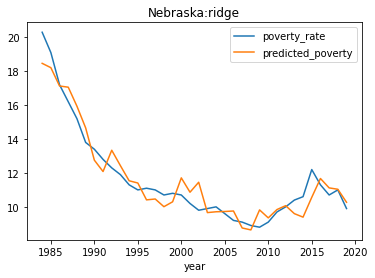

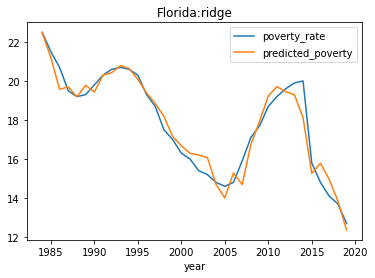

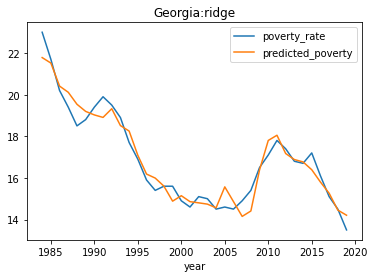

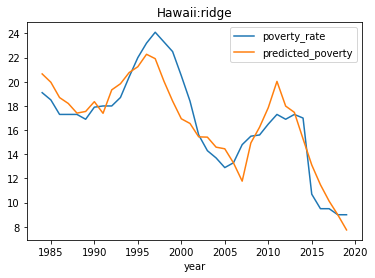

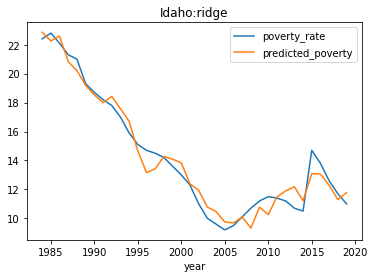

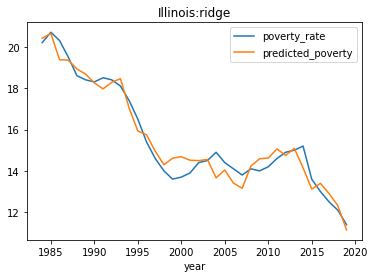

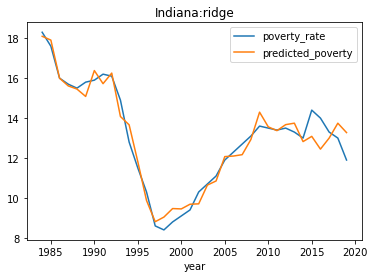

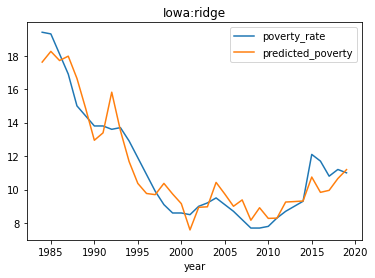

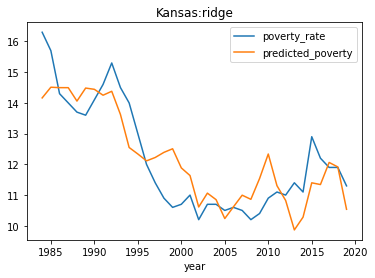

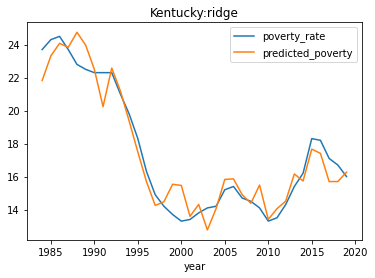

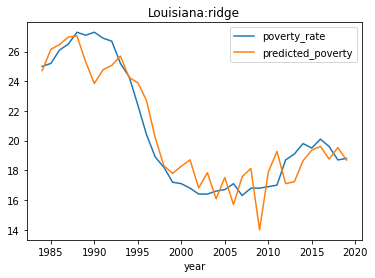

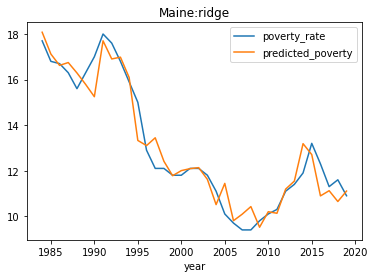

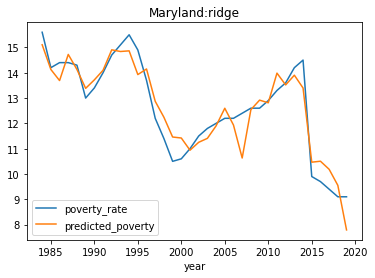

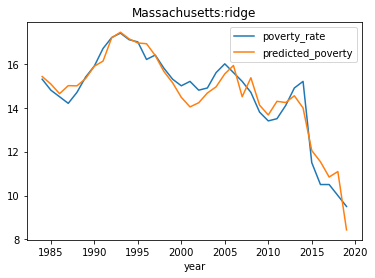

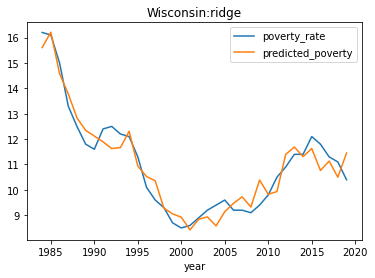

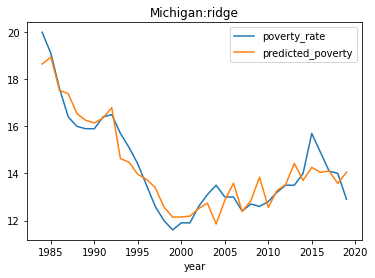

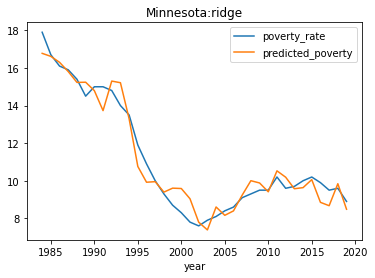

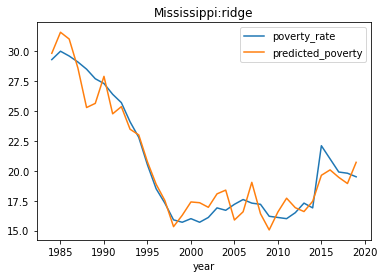

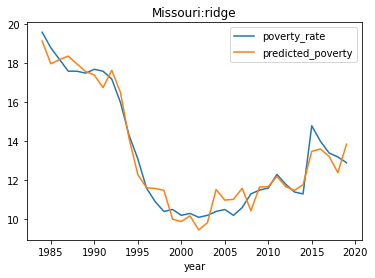

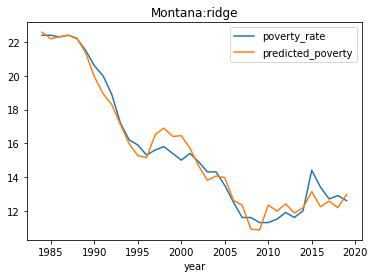

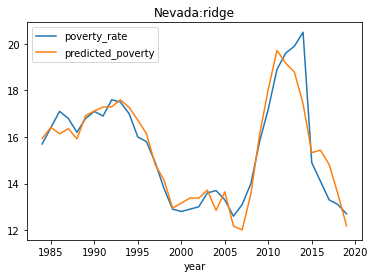

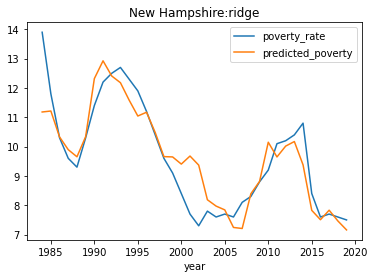

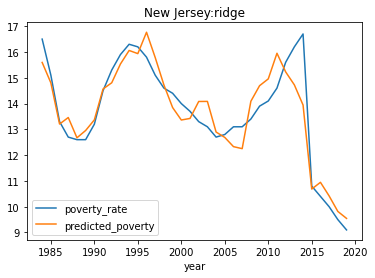

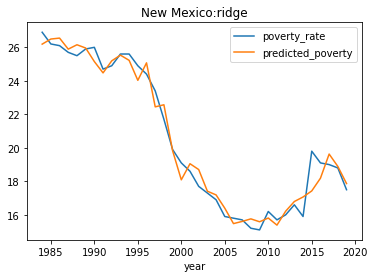

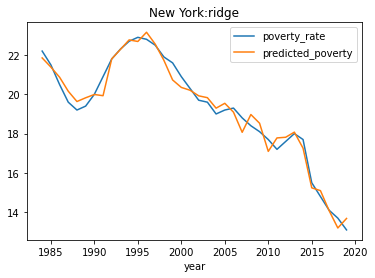

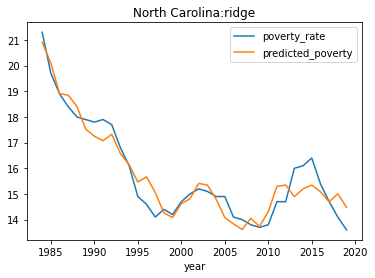

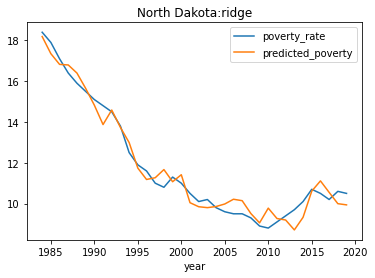

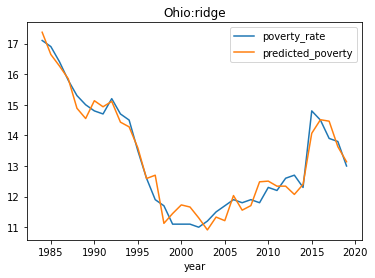

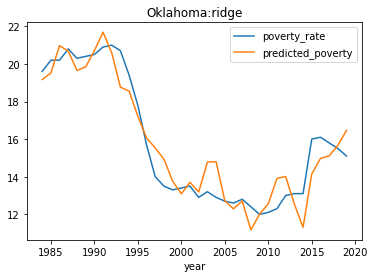

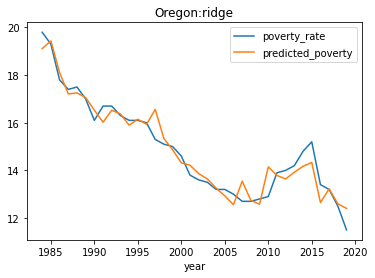

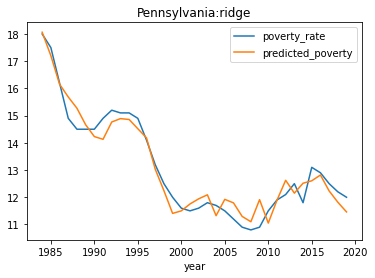

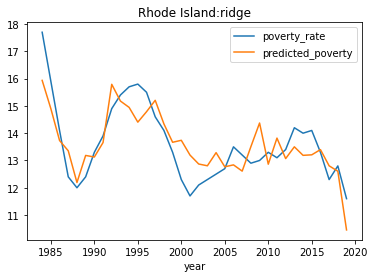

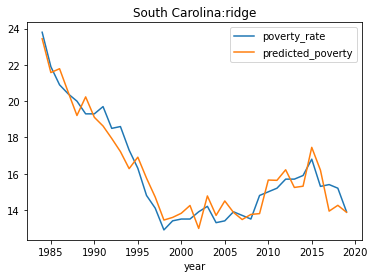

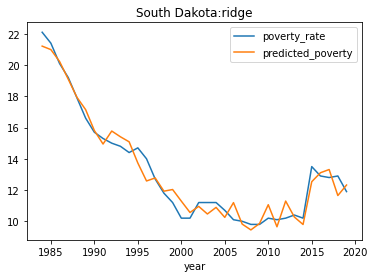

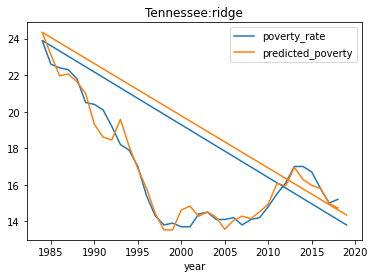

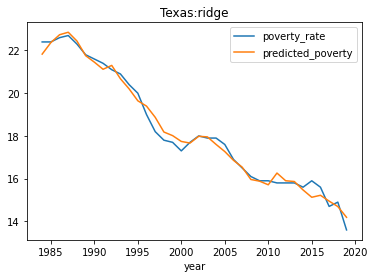

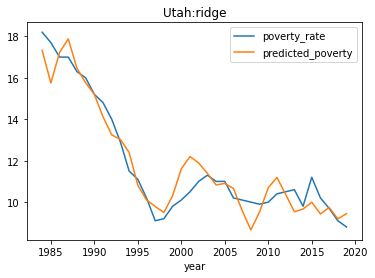

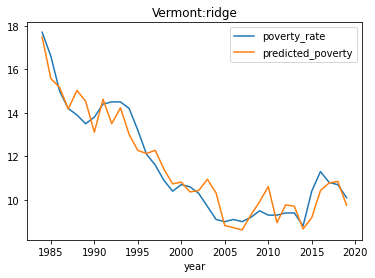

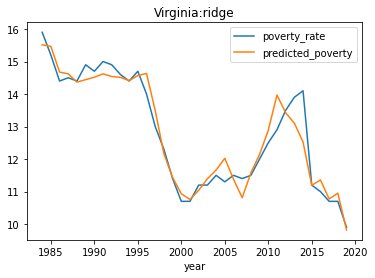

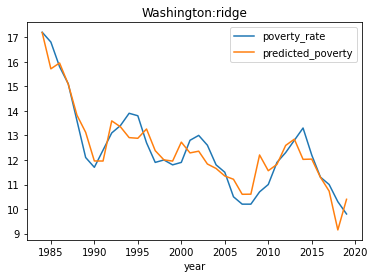

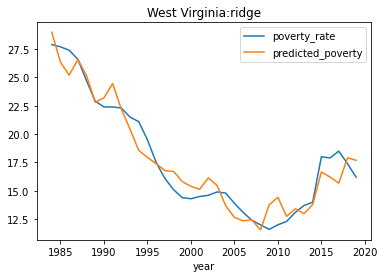

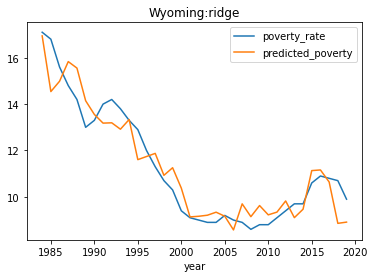

In [28]:
for state in model_df.state.unique():
    result = run_model(model_df, state, 'ridge')
    result_df = result_df.append(result, ignore_index=True)

C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.609009942766868, tolerance: 6.4402
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.86255569838671, tolerance: 8.64545163888889
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.54116819684355, tolerance: 7.001899999999999
  positive)
C:\Users\jvo1\.conda\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

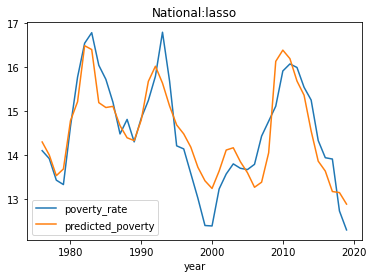

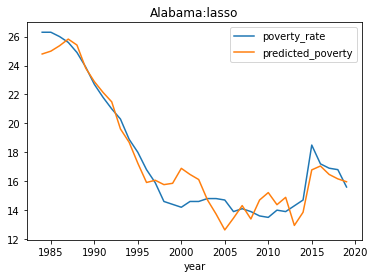

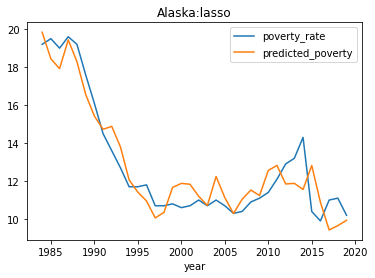

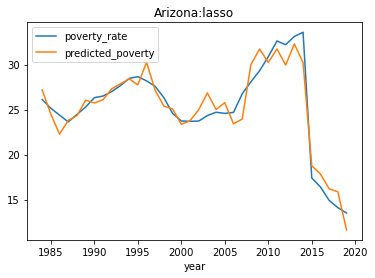

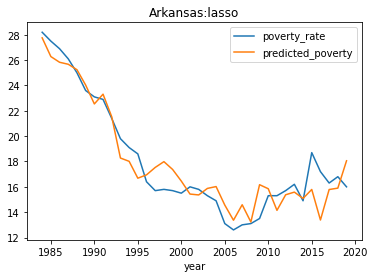

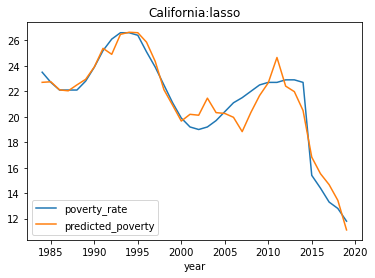

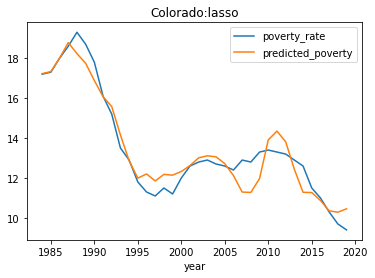

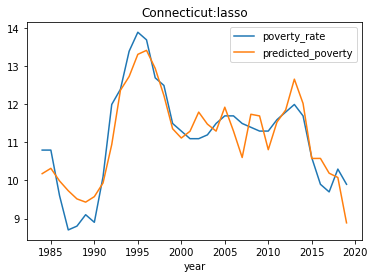

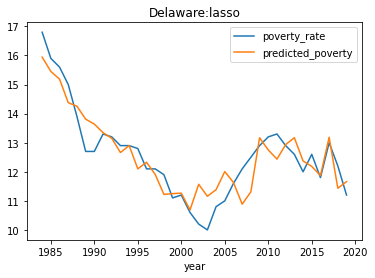

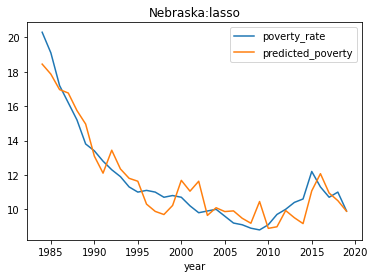

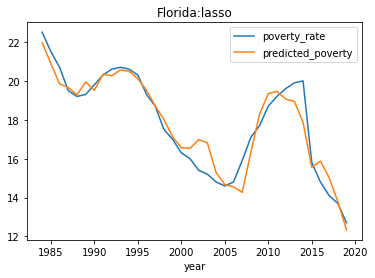

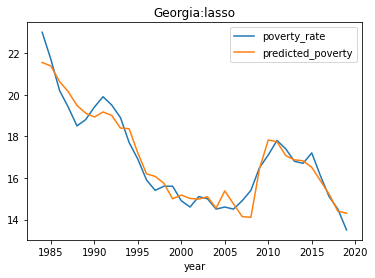

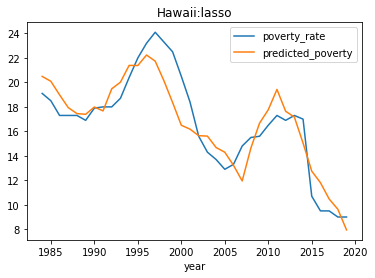

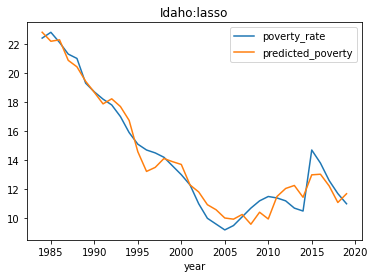

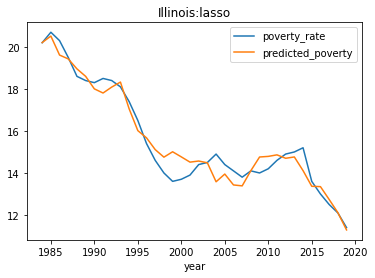

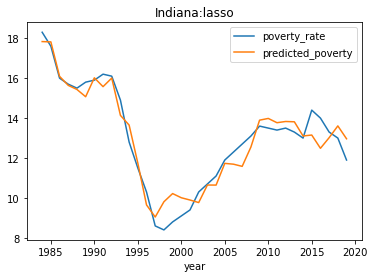

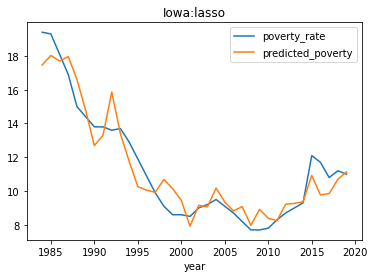

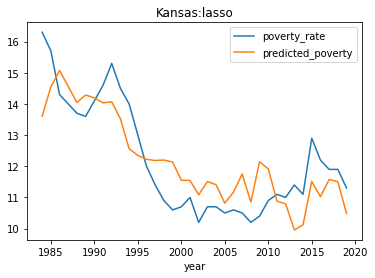

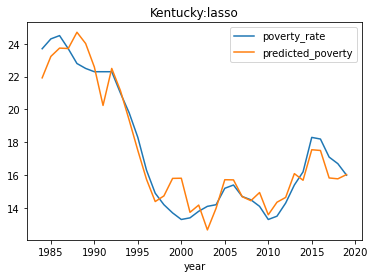

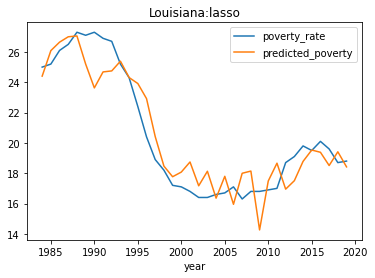

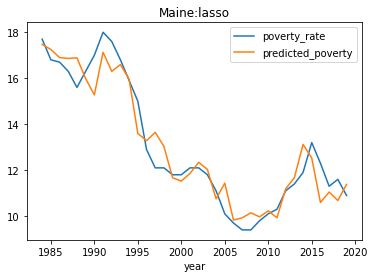

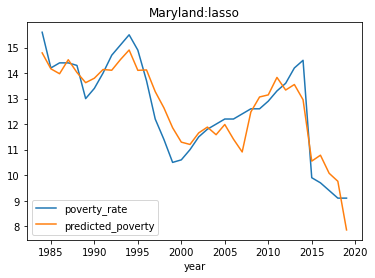

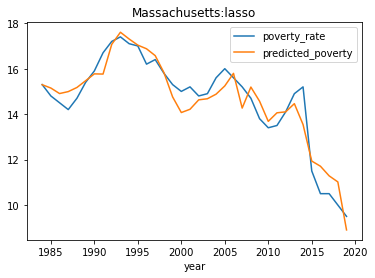

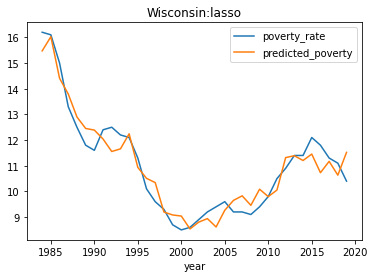

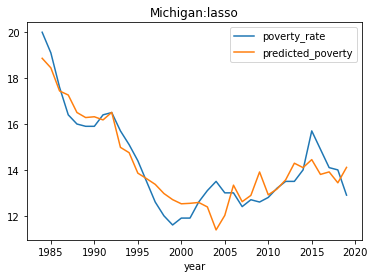

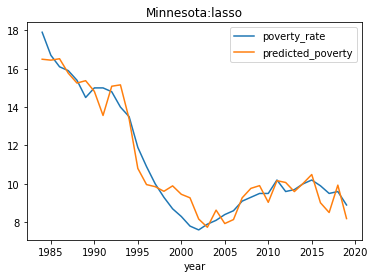

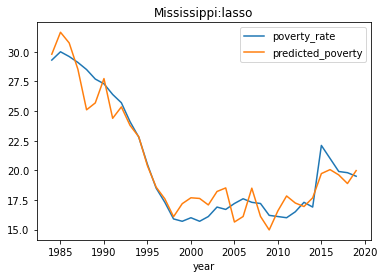

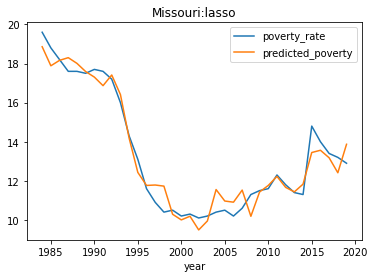

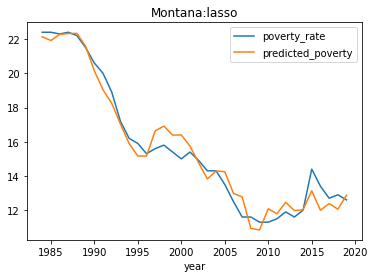

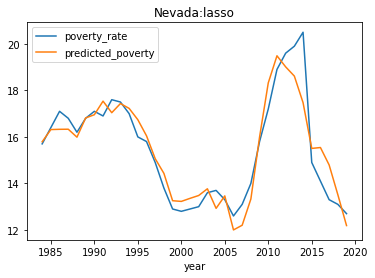

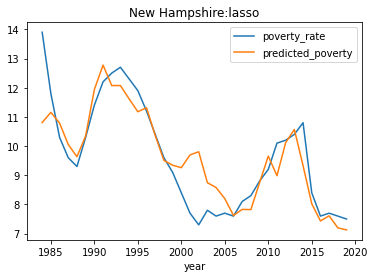

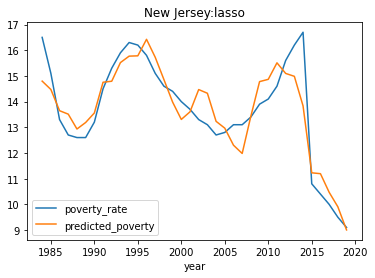

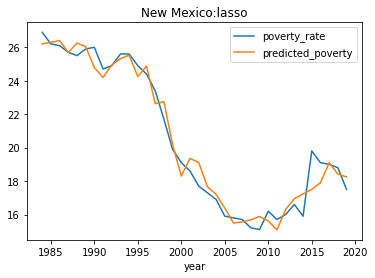

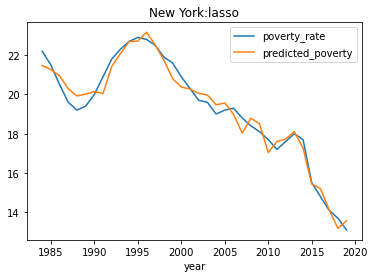

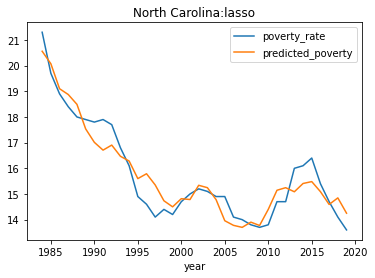

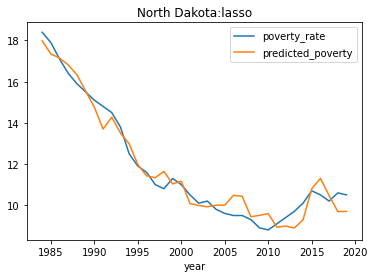

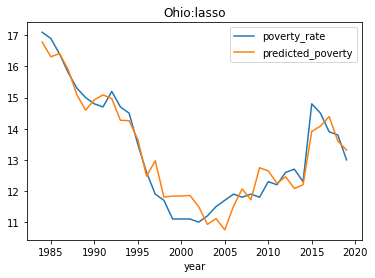

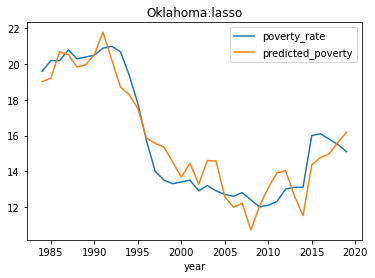

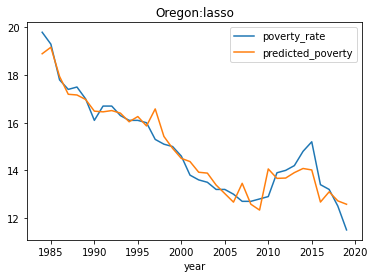

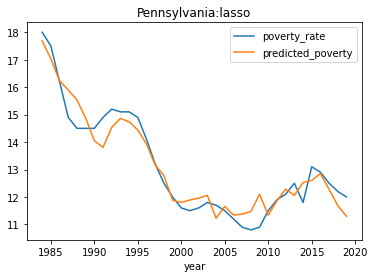

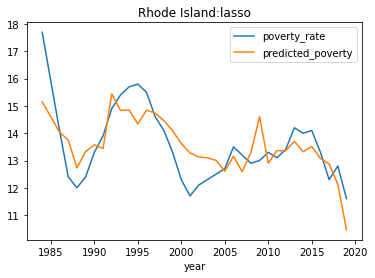

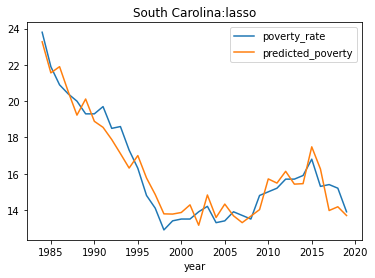

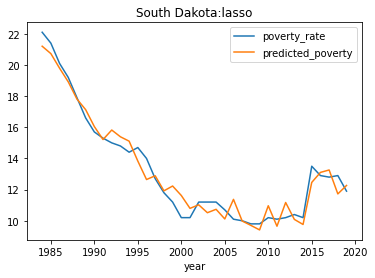

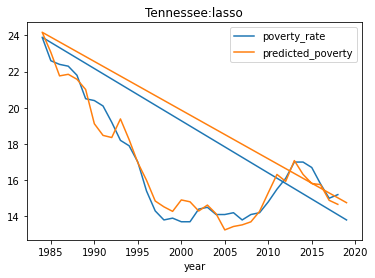

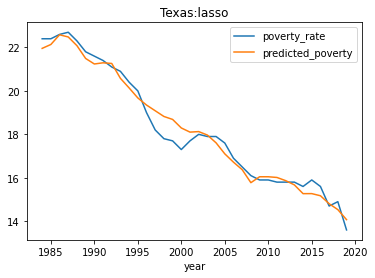

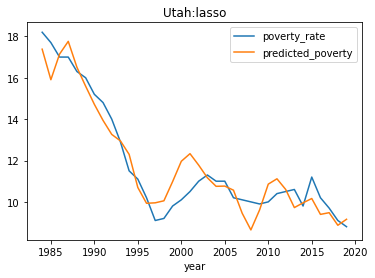

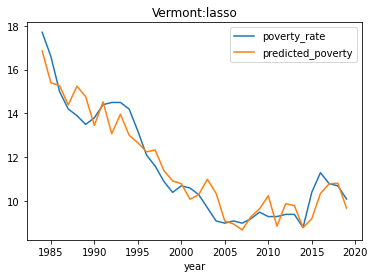

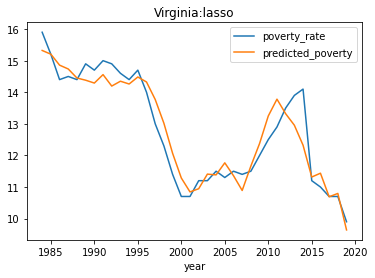

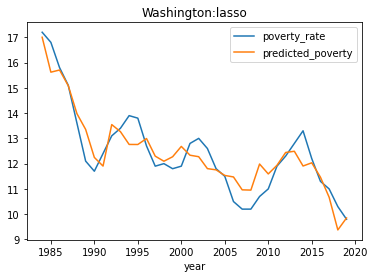

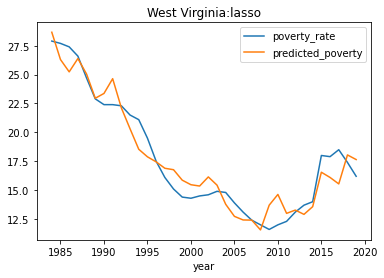

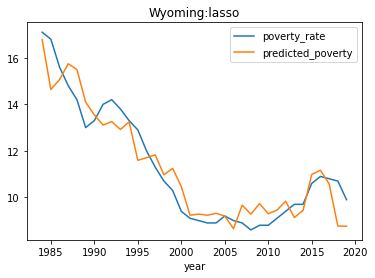

In [29]:
for state in model_df.state.unique():
    result = run_model(model_df, state, 'lasso')
 #   result_df = result_df.append(result, ignore_index=True)

In [30]:
result_df

Coefficients   Intercept  \
0    [0.004274342270884493, -10.045391027301333, 0....   -0.127145   
1    [0.002869916102275629, 1.0906756252394854, -6....  104.779778   
2    [-0.0006557213829064565, 0.6887035294558415, -...   62.027584   
3    [-0.03361001853473146, 0.27985452541826583, 12...  -54.690720   
4    [0.00794068681858852, 2.250409268893324, 1.850...   14.020458   
..                                                 ...         ...   
97   [0.014858272059011086, 0.33403324658235156, 0....   57.795234   
98   [-0.016922095767109433, 0.3738704429454671, -0...   32.248296   
99   [-0.011997266550329951, 0.615921064429069, -0....   37.286199   
100  [-0.011959780854695538, 1.03028044721243, -1.8...   55.854229   
101  [-0.004683692223822217, -0.05371244855967811, ...   59.386052   

     Mean absolute error  Mean square error   Model          State  r2 score  
0               0.390001           0.234619  linear       National  0.832870  
1               0.731487           0.816870  linear        Alabama  0.954338  
2               0.803337           0.908846  linear         Alaska  0.903805  
3               0.999175           1.515083  linear        Arizona  0.936911  
4               0.972308           1.788989  linear       Arkansas  0.908020  
..                   ...                ...     ...            ...       ...  
97              0.525974           0.452406   ridge        Vermont  0.921323  
98              0.308884           0.199832   ridge       Virginia  0.930899  
99              0.482701           0.391773   ridge     Washington  0.866250  
100             1.074943           1.734610   ridge  West Virginia  0.927792  
101             0.642593           0.664813   ridge        Wyoming  0.890007  

[102 rows x 7 columns]

In [31]:
result3_df = pd.DataFrame()
result3_df = result_df[result_df.Model=='linear'].copy()
result3_df.dtypes
r2_linear = result3_df['r2 score'].tolist()
r2_ridge = result_df.loc[result_df.Model=='ridge']['r2 score'].tolist()
result3_df['r2 score ridge']=r2_ridge
result3_df['delta r2']=result3_df['r2 score']-result3_df['r2 score ridge']
result3_df= result3_df.set_index('State').sort_values(by='delta r2', ascending=True)
result3_df

Coefficients   Intercept  \
State                                                                           
Maine           [-0.05729228654003222, 0.6197164057564623, 0.0...   71.719783   
South Carolina  [-0.007135020405715292, 0.07393121960424383, 0...   63.009259   
Colorado        [-0.0009121093417904848, 0.9281345204318638, -...   40.040468   
Wyoming         [-0.005176023753831504, -0.06098635645008642, ...   56.201816   
Tennessee       [-0.00831445505927817, 0.6297573279279756, -0....   75.289835   
New Jersey      [-0.020059367228097338, 0.33704848997084036, 0...    8.733844   
Kentucky        [0.011568333404727337, 0.4177901105894685, -1....   96.791274   
Utah            [-0.018603418195312554, 0.22762437314156758, -...   67.863232   
Oklahoma        [0.021662117618453266, 1.389998705254957, -1.3...   40.198880   
Arkansas        [0.00794068681858852, 2.250409268893324, 1.850...   14.020458   
Missouri        [0.004892927894638097, 1.2283439252718305, 1.6...   33.133464   
Maryland        [-0.008861601972875293, 1.0264941252230908, 0....   29.144305   
Iowa            [-0.0008995344773179918, 0.8093364338621072, -...   75.919729   
Pennsylvania    [-0.0034608776986128184, 0.5235089025886872, 0...   45.590810   
Texas           [-0.002756391597266234, 0.5804830277869478, -0...   43.075819   
Indiana         [-0.0010471446686421207, 1.1042730215958791, -...   55.177950   
Louisiana       [0.015711843653664574, 1.5323247380130043, -2....   39.251964   
Nevada          [-0.0033124860186938606, 0.39020812574382807, ...   14.106847   
North Dakota    [0.011875907795337603, 0.10278625938783578, -2...   54.573767   
Ohio            [0.008581976192866566, 0.4961871350124541, -1....   68.510349   
Nebraska        [-0.01620576196908826, 0.5713904905799045, 2.0...   31.266431   
Virginia        [-0.018637369441082092, 0.42733470713984056, 0...   28.752418   
Georgia         [-0.0034709175277258357, 0.602201898095977, 2....   14.602832   
New Mexico      [0.014828214911128982, 0.8704204962839486, 3.8...   30.879833   
Wisconsin       [-0.0028010752364142216, 0.3778139674288073, -...   51.668488   
Oregon          [0.006495851324116772, 0.372802812741312, -2.0...   50.207265   
South Dakota    [0.031656223685824346, 1.8379056418115216, -3....   43.651678   
California      [0.0002110562218941687, 0.41017907724172764, 4...  -27.316989   
Illinois        [-0.0033136230232899033, 0.4681585357982483, -...   49.726490   
Mississippi     [0.009505517945297593, 1.514203279523982, -5.4...  126.531299   
New York        [-0.002241885302782564, 0.10620589976049029, 2...   -2.842995   
Vermont         [0.008671734888034688, 0.19519338209796824, 2....   44.158537   
Idaho           [0.016038249625337266, 0.5693123745638746, 5.2...    7.536072   
National        [0.004274342270884493, -10.045391027301333, 0....   -0.127145   
Hawaii          [0.02176075819243448, 1.8582718046029802, -5.2...   25.898579   
Minnesota       [-0.009609729417396544, 0.4642329111596749, -4...   75.309345   
Montana         [-0.002651091903410424, 0.22562113265291314, -...   80.136508   
North Carolina  [-0.002704248599331669, 0.44423479490479084, -...   62.293754   
Alabama         [0.002869916102275629, 1.0906756252394854, -6....  104.779778   
Michigan        [-0.0024342280690010454, 0.38914668811779907, ...   60.424597   
Alaska          [-0.0006557213829064565, 0.6887035294558415, -...   62.027584   
Florida         [-0.003973800951970179, 0.2561743982634243, -2...   31.197347   
Washington      [-0.010263842970996953, 0.6916360798861272, -2...   49.382619   
New Hampshire   [-0.005895329162750987, 0.38656934398437076, 2...    4.642876   
Kansas          [0.014084293180687948, -0.2997124470467415, -2...   47.358147   
Massachusetts   [0.002285151946085332, 0.11472664519930391, -5...   22.769051   
Connecticut     [-0.010745145917836495, 0.08266783337542487, 3...  -17.355426   
Arizona         [-0.03361001853473146, 0.27985452541826583, 12...  -54.690720   
Wes

<AxesSubplot:ylabel='State'>

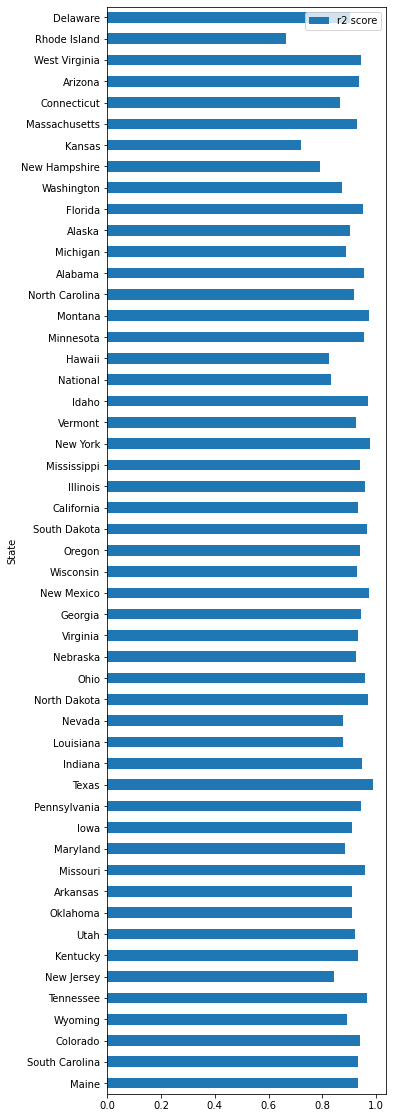

In [32]:
result3_df.plot(y='r2 score',kind='barh',use_index=True, figsize=(5,20))